Дотасет:
https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview

Можете мерять результат по 5-fold evaluation на train-set,  per user auc roc.  

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from catboost import Pool, CatBoostClassifier
import os
from os.path import join
from tqdm import trange
from tqdm.notebook import tqdm
from collections import defaultdict
from time import sleep
from sklearn.model_selection import train_test_split

In [2]:
np.__version__

'1.20.0'

In [3]:
DATA_DIR = './data'
GLOBAL_SEED = 0
K_FOLDS = 5

# Задача 1:

Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен. 

## EDA

In [4]:
train_df_raw = pd.read_csv(join(DATA_DIR, "train.csv"))
train_df_raw.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
train_df_raw.dtypes

msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                 int64
dtype: object

In [6]:
train_df_raw.isna().sum(axis=0)

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [7]:
train_df_raw.isna().sum(axis=0) / len(train_df_raw)

msno                  0.000000
song_id               0.000000
source_system_tab     0.003368
source_screen_name    0.056226
source_type           0.002920
target                0.000000
dtype: float64

In [8]:
train_df_raw.fillna('nan', inplace=True)

In [9]:
train_df_raw.nunique()

msno                   30755
song_id               359966
source_system_tab          9
source_screen_name        21
source_type               13
target                     2
dtype: int64

In [10]:
songs_df = pd.read_csv(join(DATA_DIR, 'songs.csv'))
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [11]:
songs_df.isna().sum(axis=0) / len(songs_df)

song_id        0.000000e+00
song_length    0.000000e+00
genre_ids      4.098558e-02
artist_name    0.000000e+00
composer       4.665526e-01
lyricist       8.471241e-01
language       4.354794e-07
dtype: float64

In [12]:
songs_df.dtypes

song_id         object
song_length      int64
genre_ids       object
artist_name     object
composer        object
lyricist        object
language       float64
dtype: object

In [13]:
songs_df.isna().sum(axis=0) / len(songs_df)

song_id        0.000000e+00
song_length    0.000000e+00
genre_ids      4.098558e-02
artist_name    0.000000e+00
composer       4.665526e-01
lyricist       8.471241e-01
language       4.354794e-07
dtype: float64

In [14]:
train_df = train_df_raw.merge(songs_df, on='song_id', how='left')

In [15]:
members_df = pd.read_csv(join(DATA_DIR, 'members.csv'))
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [16]:
members_df.dtypes

msno                      object
city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
expiration_date            int64
dtype: object

In [17]:
members_df.isna().sum(axis=0) / len(members_df)

msno                      0.000000
city                      0.000000
bd                        0.000000
gender                    0.578496
registered_via            0.000000
registration_init_time    0.000000
expiration_date           0.000000
dtype: float64

In [18]:
members_df.fillna('nan', inplace=True)

In [19]:
def split_year_month_day(dt):
    return dt // 10000, (dt % 10000) // 100, dt % 100

In [20]:
members_df['reg_year'], members_df['reg_month'], members_df['reg_day'] = zip(
    *members_df.registration_init_time.map(split_year_month_day)
)

In [21]:
members_df['exp_year'], members_df['exp_month'], members_df['exp_day'] = zip(
    *members_df.expiration_date.map(split_year_month_day)
)

In [22]:
members_df.drop(labels=['registration_init_time', 'expiration_date'], axis=1, inplace=True)
members_df.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via', 'reg_year',
       'reg_month', 'reg_day', 'exp_year', 'exp_month', 'exp_day'],
      dtype='object')

In [23]:
members_df.bd.loc[(members_df.bd < 5) | (members_df.bd > 100)] = np.nan

/home/anton/python-envs/recsys-env/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
songs_extra_df = pd.read_csv(join(DATA_DIR, 'song_extra_info.csv'))
songs_extra_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [25]:
def isrc_to_year(isrc):
    if isinstance(isrc, str):
        decs = int(isrc[5:7])
        if decs > 17:
            return 1900 + decs
        return 2000 + decs
    return np.nan

In [26]:
songs_extra_df['song_year'] = songs_extra_df['isrc'].apply(isrc_to_year).astype(np.float64)
songs_extra_df.drop(['isrc', 'name'], axis=1, inplace=True)

In [27]:
songs_extra_df.head()

,song_id,song_year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012.0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,2016.0
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,2008.0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,2013.0
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,2013.0


In [28]:
train_df = train_df.merge(members_df, on='msno', how='left')

In [29]:
train_df = train_df.merge(songs_extra_df, on='song_id', how='left')

In [30]:
train_df.dtypes

msno                   object
song_id                object
source_system_tab      object
source_screen_name     object
source_type            object
target                  int64
song_length           float64
genre_ids              object
artist_name            object
composer               object
lyricist               object
language              float64
city                    int64
bd                    float64
gender                 object
registered_via          int64
reg_year                int64
reg_month               int64
reg_day                 int64
exp_year                int64
exp_month               int64
exp_day                 int64
song_year             float64
dtype: object

In [31]:
train_df.language.unique()

array([52., -1., 31.,  3., 17., 10., 24., 59., 45., nan, 38.])

In [32]:
train_df.language = train_df.language.fillna(0).astype('int64')

In [33]:
train_df.dtypes

msno                   object
song_id                object
source_system_tab      object
source_screen_name     object
source_type            object
target                  int64
song_length           float64
genre_ids              object
artist_name            object
composer               object
lyricist               object
language                int64
city                    int64
bd                    float64
gender                 object
registered_via          int64
reg_year                int64
reg_month               int64
reg_day                 int64
exp_year                int64
exp_month               int64
exp_day                 int64
song_year             float64
dtype: object

Заменим набор жанров на эмпирическую вероятность того, что юзер послушает песню с данным набором жанров (в предположении, что жанры независимы)

In [34]:
user_genre_counter = dict((msno, defaultdict(int)) for msno in train_df.msno.unique().tolist())

In [35]:
for msno, genre_ids in zip(train_df.msno, train_df.genre_ids):
    if pd.notna(genre_ids):
        user_genre_counter[msno]['num_songs_listened'] += 1
        for genre in genre_ids.split('|'):
            user_genre_counter[msno][genre] += 1

In [36]:
user_genre_counter['FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=']

defaultdict(int,
            {'num_songs_listened': 5410,
             '359': 182,
             '1011': 39,
             '1259': 674,
             '465': 2369,
             '1609': 1042,
             '139': 190,
             '691': 2,
             '2022': 194,
             '1616': 58,
             '2058': 13,
             '2072': 4,
             '125': 60,
             '109': 62,
             '444': 201,
             '1955': 3,
             '352': 11,
             '1995': 11,
             '921': 112,
             '1040': 1,
             '2093': 6,
             '423': 2,
             '458': 281,
             '451': 28,
             '430': 11,
             '437': 8,
             '2122': 37,
             '880': 2,
             '118': 1,
             '2107': 15,
             '2176': 4,
             '1572': 10,
             '275': 10,
             '829': 4,
             '958': 18,
             '2130': 1,
             '798': 13,
             '2157': 11,
             '947': 12,
             '

In [37]:
user_genre_logprobs = []
for msno, genre_ids in zip(train_df.msno, train_df.genre_ids):
    if pd.isna(genre_ids):
        user_genre_logprobs.append(np.nan)
    else:
        user_genre_logprobs.append(
            np.log([
                user_genre_counter[msno][genre] / user_genre_counter[msno]['num_songs_listened']
            for genre in genre_ids.split('|')]).sum()
        )
train_df['genres_logprob'] = np.array(user_genre_logprobs)

In [38]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day,song_year,genres_logprob
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,nan,7,2012,1,2,2017,10,5,2016.0,-3.391998
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,...,female,9,2011,5,25,2017,9,11,1999.0,-2.528175
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,female,9,2011,5,25,2017,9,11,2006.0,-2.528175
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,female,9,2011,5,25,2017,9,11,2010.0,-6.419995
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,nan,7,2012,1,2,2017,10,5,2016.0,-4.932443


In [39]:
del user_genre_counter, user_genre_logprobs

Сделаем то же самое с исполнителем (на композитора и автора текста забьем)

In [40]:
user_artist_counter = dict((msno, defaultdict(int)) for msno in train_df.msno.unique().tolist())
for msno, artist in zip(train_df.msno, train_df.artist_name):
    if pd.notna(artist):
        user_artist_counter[msno]['num_songs_listened'] += 1
        user_artist_counter[msno][artist] += 1
        
user_artist_logprobs = []
for msno, artist in zip(train_df.msno, train_df.artist_name):
    if pd.isna(artist):
        user_artist_logprobs.append(np.nan)
    else:
        user_artist_logprobs.append(
            np.log(user_artist_counter[msno][artist] / user_artist_counter[msno]['num_songs_listened'])
        )
train_df['artist_logprob'] = np.array(user_artist_logprobs)

del user_artist_counter, user_artist_logprobs

In [41]:
train_df.dtypes

msno                   object
song_id                object
source_system_tab      object
source_screen_name     object
source_type            object
target                  int64
song_length           float64
genre_ids              object
artist_name            object
composer               object
lyricist               object
language                int64
city                    int64
bd                    float64
gender                 object
registered_via          int64
reg_year                int64
reg_month               int64
reg_day                 int64
exp_year                int64
exp_month               int64
exp_day                 int64
song_year             float64
genres_logprob        float64
artist_logprob        float64
dtype: object

In [42]:
y = train_df.target
X = train_df.drop(
    ['msno', 'song_id', 'target', 'genre_ids', 'artist_name', 'composer', 'lyricist'],
    axis=1
)

X.dtypes

source_system_tab      object
source_screen_name     object
source_type            object
song_length           float64
language                int64
city                    int64
bd                    float64
gender                 object
registered_via          int64
reg_year                int64
reg_month               int64
reg_day                 int64
exp_year                int64
exp_month               int64
exp_day                 int64
song_year             float64
genres_logprob        float64
artist_logprob        float64
dtype: object

In [43]:
del train_df_raw, songs_df, members_df

In [44]:
CAT_FEATURES = [0, 1, 2, 4, 5, 7, 8]

In [45]:
for idx, col in enumerate(X.columns):
    if idx in CAT_FEATURES:
        X[col] = X[col].astype('category')

In [46]:
X.dtypes

source_system_tab     category
source_screen_name    category
source_type           category
song_length            float64
language              category
city                  category
bd                     float64
gender                category
registered_via        category
reg_year                 int64
reg_month                int64
reg_day                  int64
exp_year                 int64
exp_month                int64
exp_day                  int64
song_year              float64
genres_logprob         float64
artist_logprob         float64
dtype: object

In [47]:
MODEL_PARAMS = {
    'iterations': 100,
    'depth': 8,
    'num_leaves': 256,
    'min_data_in_leaf': 10,
    'random_seed': GLOBAL_SEED,
    'learning_rate': 0.4,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 10,
}

In [48]:
def cross_validation(X, y, k_folds):
    np.random.seed(GLOBAL_SEED)
    idx = np.random.permutation(len(y))
    folds = np.array_split(idx, k_folds)
  
    aucs = []
    
    for split, val_inds in enumerate(folds):
        print(f"Taking {split} split as validation set")
        train_inds = np.setdiff1d(idx, val_inds)

        X_train, y_train = X.iloc[train_inds], y.iloc[train_inds]
        X_val, y_val = X.iloc[val_inds], y.iloc[val_inds]
        
        model = CatBoostClassifier(**MODEL_PARAMS)
        model.fit(
            X_train, y_train,
            cat_features=CAT_FEATURES,
            eval_set=(X_val, y_val),
            verbose=True
        )
        
        probs = model.predict_proba(X_val)[:, 1]
        
        aucs.append(roc_auc_score(y_val.values, probs))
        del model
        sleep(1)
        
    return aucs

In [49]:
fold_metrics= cross_validation(X, y, K_FOLDS)

Taking 0 split as validation set
0:	test: 0.6655635	best: 0.6655635 (0)	total: 1.8s	remaining: 2m 58s
1:	test: 0.6679925	best: 0.6679925 (1)	total: 3.43s	remaining: 2m 47s
2:	test: 0.6689157	best: 0.6689157 (2)	total: 4.88s	remaining: 2m 37s
3:	test: 0.6700900	best: 0.6700900 (3)	total: 6.39s	remaining: 2m 33s
4:	test: 0.6727744	best: 0.6727744 (4)	total: 8.27s	remaining: 2m 37s
5:	test: 0.6738926	best: 0.6738926 (5)	total: 9.77s	remaining: 2m 33s
6:	test: 0.6755610	best: 0.6755610 (6)	total: 11.3s	remaining: 2m 30s
7:	test: 0.6764251	best: 0.6764251 (7)	total: 12.9s	remaining: 2m 27s
8:	test: 0.6778368	best: 0.6778368 (8)	total: 14.5s	remaining: 2m 26s
9:	test: 0.6786746	best: 0.6786746 (9)	total: 16s	remaining: 2m 24s
10:	test: 0.6794269	best: 0.6794269 (10)	total: 17.5s	remaining: 2m 21s
11:	test: 0.6804289	best: 0.6804289 (11)	total: 19s	remaining: 2m 19s
12:	test: 0.6811076	best: 0.6811076 (12)	total: 20.6s	remaining: 2m 17s
13:	test: 0.6816551	best: 0.6816551 (13)	total: 22.1s	re

14:	test: 0.6815410	best: 0.6815410 (14)	total: 29.2s	remaining: 2m 45s
15:	test: 0.6820924	best: 0.6820924 (15)	total: 31.1s	remaining: 2m 43s
16:	test: 0.6829002	best: 0.6829002 (16)	total: 32.9s	remaining: 2m 40s
17:	test: 0.6834212	best: 0.6834212 (17)	total: 34.9s	remaining: 2m 39s
18:	test: 0.6838843	best: 0.6838843 (18)	total: 36.8s	remaining: 2m 36s
19:	test: 0.6843153	best: 0.6843153 (19)	total: 38.8s	remaining: 2m 35s
20:	test: 0.6850720	best: 0.6850720 (20)	total: 40.7s	remaining: 2m 33s
21:	test: 0.6856542	best: 0.6856542 (21)	total: 42.6s	remaining: 2m 31s
22:	test: 0.6860607	best: 0.6860607 (22)	total: 44.5s	remaining: 2m 28s
23:	test: 0.6866666	best: 0.6866666 (23)	total: 46.2s	remaining: 2m 26s
24:	test: 0.6871542	best: 0.6871542 (24)	total: 48s	remaining: 2m 24s
25:	test: 0.6875788	best: 0.6875788 (25)	total: 49.8s	remaining: 2m 21s
26:	test: 0.6883217	best: 0.6883217 (26)	total: 51.5s	remaining: 2m 19s
27:	test: 0.6890465	best: 0.6890465 (27)	total: 53.3s	remaining: 2

28:	test: 0.6891059	best: 0.6891059 (28)	total: 53.1s	remaining: 2m 10s
29:	test: 0.6894214	best: 0.6894214 (29)	total: 55.1s	remaining: 2m 8s
30:	test: 0.6897022	best: 0.6897022 (30)	total: 56.8s	remaining: 2m 6s
31:	test: 0.6899689	best: 0.6899689 (31)	total: 58.5s	remaining: 2m 4s
32:	test: 0.6902025	best: 0.6902025 (32)	total: 1m	remaining: 2m 2s
33:	test: 0.6905547	best: 0.6905547 (33)	total: 1m 2s	remaining: 2m
34:	test: 0.6908403	best: 0.6908403 (34)	total: 1m 3s	remaining: 1m 58s
35:	test: 0.6920371	best: 0.6920371 (35)	total: 1m 5s	remaining: 1m 56s
36:	test: 0.6922510	best: 0.6922510 (36)	total: 1m 7s	remaining: 1m 54s
37:	test: 0.6925717	best: 0.6925717 (37)	total: 1m 9s	remaining: 1m 53s
38:	test: 0.6933850	best: 0.6933850 (38)	total: 1m 11s	remaining: 1m 51s
39:	test: 0.6938007	best: 0.6938007 (39)	total: 1m 12s	remaining: 1m 49s
40:	test: 0.6946762	best: 0.6946762 (40)	total: 1m 14s	remaining: 1m 47s
41:	test: 0.6948805	best: 0.6948805 (41)	total: 1m 16s	remaining: 1m 45s

42:	test: 0.6968462	best: 0.6968462 (42)	total: 1m 18s	remaining: 1m 43s
43:	test: 0.6971029	best: 0.6971029 (43)	total: 1m 20s	remaining: 1m 42s
44:	test: 0.6973515	best: 0.6973515 (44)	total: 1m 22s	remaining: 1m 40s
45:	test: 0.6976882	best: 0.6976882 (45)	total: 1m 23s	remaining: 1m 38s
46:	test: 0.6980065	best: 0.6980065 (46)	total: 1m 25s	remaining: 1m 36s
47:	test: 0.6984888	best: 0.6984888 (47)	total: 1m 27s	remaining: 1m 34s
48:	test: 0.6989171	best: 0.6989171 (48)	total: 1m 29s	remaining: 1m 32s
49:	test: 0.6992682	best: 0.6992682 (49)	total: 1m 31s	remaining: 1m 31s
50:	test: 0.7000025	best: 0.7000025 (50)	total: 1m 32s	remaining: 1m 29s
51:	test: 0.7001707	best: 0.7001707 (51)	total: 1m 34s	remaining: 1m 27s
52:	test: 0.7006374	best: 0.7006374 (52)	total: 1m 36s	remaining: 1m 25s
53:	test: 0.7011087	best: 0.7011087 (53)	total: 1m 38s	remaining: 1m 23s
54:	test: 0.7012756	best: 0.7012756 (54)	total: 1m 39s	remaining: 1m 21s
55:	test: 0.7018964	best: 0.7018964 (55)	total: 1m 

55:	test: 0.7023929	best: 0.7023929 (55)	total: 1m 40s	remaining: 1m 18s
56:	test: 0.7026264	best: 0.7026264 (56)	total: 1m 42s	remaining: 1m 17s
57:	test: 0.7028811	best: 0.7028811 (57)	total: 1m 44s	remaining: 1m 15s
58:	test: 0.7031813	best: 0.7031813 (58)	total: 1m 46s	remaining: 1m 13s
59:	test: 0.7034585	best: 0.7034585 (59)	total: 1m 47s	remaining: 1m 11s
60:	test: 0.7036274	best: 0.7036274 (60)	total: 1m 49s	remaining: 1m 10s
61:	test: 0.7039758	best: 0.7039758 (61)	total: 1m 51s	remaining: 1m 8s
62:	test: 0.7043718	best: 0.7043718 (62)	total: 1m 53s	remaining: 1m 6s
63:	test: 0.7049332	best: 0.7049332 (63)	total: 1m 54s	remaining: 1m 4s
64:	test: 0.7051339	best: 0.7051339 (64)	total: 1m 56s	remaining: 1m 2s
65:	test: 0.7055060	best: 0.7055060 (65)	total: 1m 58s	remaining: 1m
66:	test: 0.7057616	best: 0.7057616 (66)	total: 2m	remaining: 59.1s
67:	test: 0.7059095	best: 0.7059095 (67)	total: 2m 1s	remaining: 57.3s
68:	test: 0.7060523	best: 0.7060523 (68)	total: 2m 3s	remaining: 5

In [50]:
print(f"Mean roc-auc across {K_FOLDS} folds: {np.mean(fold_metrics)}")

Mean roc-auc across 5 folds: 0.712459421139585


# Задача 2: 
Пользуясь информацией о треках построить неклассические эмбеддинги и попробовать использовать их:

<ol>
    <li>показать симилары глазами</li>
    <li>в качестве рекоммендера вместо GBDT (разницу в метриках)</li> 
    <li>стек с GBDT (прирост / отсутствие / почему /, SHAP values)</li>
</ol>

In [49]:
import shap
from gensim.models import Word2Vec

## Неклассические эмбеддинги

In [50]:
WORD2VEC_EMBED_DIM = 32

In [51]:
WORD2VEC_PARAMS = {
    'model': {
        'window': 10,
        'vector_size': WORD2VEC_EMBED_DIM,
        'sg': 1,
        'hs': 0,
        'negative': 10,
        'alpha': 0.05,
        'min_alpha': 0.0001,
        'workers': 4,
        'seed': GLOBAL_SEED
    },
    'training': {
        'epochs': 5
    }
}

In [52]:
def get_user_embeddings(w2v, df):
    user_embeddings = defaultdict(lambda: np.zeros(WORD2VEC_EMBED_DIM))
    user_counts = defaultdict(int)
    for user_id, song_id, target in tqdm(
        zip(df['msno'], df['song_id'], df['target']), 
        desc='Building user embeddings'
    ):
        if target != 1:
            continue
        if song_id in w2v:
            user_embeddings[user_id] += w2v[song_id]
            user_counts[user_id] += 1
    for user_id in user_embeddings.keys():
        user_embeddings[user_id] /= user_counts[user_id]
    return user_embeddings

In [53]:
def train_word2vec(df):
    sessions = []
    for user_ids in tqdm(df.groupby(by=['msno']).groups.values(), desc='Building sessions'):
        sessions.append(df['song_id'].iloc[user_ids].tolist())

    word2vec = Word2Vec(**WORD2VEC_PARAMS['model'])
    print('Bulding vocabulary...')
    word2vec.build_vocab(sessions, progress_per=1000)
    print('Training word2vec...')
    word2vec.train(sessions, total_examples=word2vec.corpus_count, **WORD2VEC_PARAMS['training'])
    user_embeddings = get_user_embeddings(word2vec.wv, df)
    return user_embeddings, word2vec
    

In [54]:
user_embeddings, word2vec = train_word2vec(train_df)

Building sessions:   0%|          | 0/30755 [00:00<?, ?it/s]

Bulding vocabulary...
Training word2vec...


Building user embeddings: 0it [00:00, ?it/s]

In [55]:
def get_similars(song_id, topn=10):
    song_embedding = word2vec.wv[song_id]
    similars = word2vec.wv.similar_by_vector(song_embedding, topn=topn+1)[1:]
    return similars

In [56]:
np.linalg.norm(user_embeddings['FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg='])

1.9051757122242177

In [57]:
songs_df = pd.read_csv(join(DATA_DIR, 'songs.csv'))

In [58]:
songs_extra_df = pd.read_csv(join(DATA_DIR, 'song_extra_info.csv'))

In [59]:
songs_df.columns

Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')

In [60]:
songs_df[songs_df.artist_name == 'Kanye West'].head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
662,HAk0G8u7Yu2ljX4D7YLcA2P6im4MPx5Rb5Q13wdRL8Q=,236100,1259,Kanye West,Kanye West| Andrew Dawson| Noah Goldstein| Mik...,NaN,52.0
1400,rjHA0Nga+XVFqG05VKykST7Sp8ztJeWa9/GWq9Yc7LI=,332382,1259,Kanye West,Kanye West| Stepan Taft| Sean Anderson| Terren...,NaN,52.0
2372,1Ut67Cwg3K+x5REruzcUyaDm17T2AgOvJLDvVJMiaBE=,287416,1259,Kanye West,NaN,NaN,52.0
2439,YLo9cVOVI9YfBJxb77JbYfk0R02Fh2zdZ4PXFWk1E3c=,206936,1259,Kanye West,Kanye West| John Stephens| A. Davis| Faheem Na...,NaN,52.0
5845,qwhfksZux8hV40qCAsSMJq8t9UKLvZT5n9rkcGTF8Po=,243438,1259,Kanye West,Kanye West| Labi Siffre,NaN,52.0


In [61]:
songs_df = songs_df.merge(songs_extra_df,on='song_id', how='inner')

songs_df.columns

Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language', 'name', 'isrc'],
      dtype='object')

In [62]:
songs_df[(songs_df.artist_name == 'Kanye West') & (songs_df.name == 'Mercy')]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
1400,rjHA0Nga+XVFqG05VKykST7Sp8ztJeWa9/GWq9Yc7LI=,332382,1259,Kanye West,Kanye West| Stepan Taft| Sean Anderson| Terren...,NaN,52.0,Mercy,USUM71203564


In [63]:
song_id = 'rjHA0Nga+XVFqG05VKykST7Sp8ztJeWa9/GWq9Yc7LI='

Посмотрим на симилары для данной песни

In [64]:
for sim_id, sim_score in get_similars(song_id):
    artist_name = songs_df[songs_df.song_id == sim_id].artist_name.values.item()
    song_name = songs_df[songs_df.song_id == sim_id].name.values.item()
    print(f'Score: {sim_score}, artist: {artist_name},  song: {song_name}')

Score: 0.902816891670227, artist: Jay-Z,  song: F.U.T.W.
Score: 0.8957455158233643, artist: A$AP Rocky,  song: F**kin' Problems
Score: 0.8906581997871399, artist: Jay-Z,  song: Big Pimpin'
Score: 0.8895015120506287, artist: Nas,  song: Stay
Score: 0.8738152980804443, artist: Kanye West,  song: Stronger(更強)
Score: 0.867067277431488, artist: Q-Tip,  song: Vivrant Thing
Score: 0.8647993803024292, artist: The Game,  song: Bulletproof Diaries
Score: 0.8623424172401428, artist: Young Gunz,  song: Can't Stop| Won't Stop
Score: 0.861735463142395, artist: Jay-Z,  song: Run This Town
Score: 0.8611681461334229, artist: Bow Wow,  song: Bow Wow (That's My Name)


Выглядит неплохо

## Word2Vec как рекомендательная система

In [65]:
def word2vec_similarity(user_embedding, song_embedding):
    user_norm = np.linalg.norm(user_embedding)
    song_norm = np.linalg.norm(song_embedding)
    if user_norm < 1e-8 or song_norm < 1e-8:
        return 0.
    return user_embedding.dot(song_embedding) / (user_norm * song_norm)

In [66]:
def word2vec_ranking(w2v, df):
    similarities = []
    for user_id, song_id in tqdm(zip(df['msno'], df['song_id']), desc='ranking'):
        user_embedding = user_embeddings[user_id]
        song_embedding = w2v[song_id] if song_id in w2v else np.zeros(WORD2VEC_EMBED_DIM)
        score = word2vec_similarity(user_embedding, song_embedding)
        similarities.append(score)
    return np.array(similarities)

In [67]:
scores = word2vec_ranking(word2vec.wv, train_df)

ranking: 0it [00:00, ?it/s]

In [68]:
len(train_df)

7377418

In [69]:
roc_auc_score(train_df.target.values, scores)

0.6713042976687551

Получилось довольно ощутимо хуже, чем GBDT. Давайте теперь посмотрим, что будет, если передать GBDT similarity score как фичу

## GBDT + Word2Vec

In [72]:
del train_df, songs_df, songs_extra_df, word2vec

In [70]:
X['w2v_sim'] = scores

In [71]:
X.dtypes

source_system_tab     category
source_screen_name    category
source_type           category
song_length            float64
language              category
city                  category
bd                     float64
gender                category
registered_via        category
reg_year                 int64
reg_month                int64
reg_day                  int64
exp_year                 int64
exp_month                int64
exp_day                  int64
song_year              float64
genres_logprob         float64
artist_logprob         float64
w2v_sim                float64
dtype: object

In [73]:
X.head()

,source_system_tab,source_screen_name,source_type,song_length,language,city,bd,gender,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day,song_year,genres_logprob,artist_logprob,w2v_sim
0,explore,Explore,online-playlist,206471.0,52,1,NaN,nan,7,2012,1,2,2017,10,5,2016.0,-3.391998,-7.515889,0.591784
1,my library,Local playlist more,local-playlist,284584.0,52,13,24.0,female,9,2011,5,25,2017,9,11,1999.0,-2.528175,-3.254886,0.000000
2,my library,Local playlist more,local-playlist,225396.0,52,13,24.0,female,9,2011,5,25,2017,9,11,2006.0,-2.528175,-5.739793,0.000000
3,my library,Local playlist more,local-playlist,255512.0,-1,13,24.0,female,9,2011,5,25,2017,9,11,2010.0,-6.419995,-6.432940,0.000000
4,explore,Explore,online-playlist,187802.0,52,1,NaN,nan,7,2012,1,2,2017,10,5,2016.0,-4.932443,-8.614501,0.515339


In [74]:
fold_metrics = cross_validation(X, y, K_FOLDS)
print(f"Mean roc-auc across {K_FOLDS} folds: {np.mean(fold_metrics)}")

Taking 0 split as validation set
0:	test: 0.7142012	best: 0.7142012 (0)	total: 1.79s	remaining: 2m 57s
1:	test: 0.7179113	best: 0.7179113 (1)	total: 3.25s	remaining: 2m 39s
2:	test: 0.7204482	best: 0.7204482 (2)	total: 4.76s	remaining: 2m 33s
3:	test: 0.7256566	best: 0.7256566 (3)	total: 6.46s	remaining: 2m 34s
4:	test: 0.7280512	best: 0.7280512 (4)	total: 8.03s	remaining: 2m 32s
5:	test: 0.7293512	best: 0.7293512 (5)	total: 9.58s	remaining: 2m 30s
6:	test: 0.7302946	best: 0.7302946 (6)	total: 11.1s	remaining: 2m 27s
7:	test: 0.7313702	best: 0.7313702 (7)	total: 12.7s	remaining: 2m 25s
8:	test: 0.7323101	best: 0.7323101 (8)	total: 14.2s	remaining: 2m 23s
9:	test: 0.7329364	best: 0.7329364 (9)	total: 15.7s	remaining: 2m 21s
10:	test: 0.7339794	best: 0.7339794 (10)	total: 17.4s	remaining: 2m 20s
11:	test: 0.7346207	best: 0.7346207 (11)	total: 18.9s	remaining: 2m 18s
12:	test: 0.7351388	best: 0.7351388 (12)	total: 20.4s	remaining: 2m 16s
13:	test: 0.7355451	best: 0.7355451 (13)	total: 22s

14:	test: 0.7347159	best: 0.7347159 (14)	total: 26.6s	remaining: 2m 30s
15:	test: 0.7353877	best: 0.7353877 (15)	total: 28.4s	remaining: 2m 29s
16:	test: 0.7360358	best: 0.7360358 (16)	total: 30.2s	remaining: 2m 27s
17:	test: 0.7364391	best: 0.7364391 (17)	total: 31.9s	remaining: 2m 25s
18:	test: 0.7368936	best: 0.7368936 (18)	total: 33.7s	remaining: 2m 23s
19:	test: 0.7373714	best: 0.7373714 (19)	total: 35.5s	remaining: 2m 22s
20:	test: 0.7376021	best: 0.7376021 (20)	total: 37.2s	remaining: 2m 20s
21:	test: 0.7378181	best: 0.7378181 (21)	total: 38.9s	remaining: 2m 18s
22:	test: 0.7381785	best: 0.7381785 (22)	total: 40.7s	remaining: 2m 16s
23:	test: 0.7387083	best: 0.7387083 (23)	total: 42.5s	remaining: 2m 14s
24:	test: 0.7390741	best: 0.7390741 (24)	total: 44.3s	remaining: 2m 12s
25:	test: 0.7393266	best: 0.7393266 (25)	total: 46s	remaining: 2m 11s
26:	test: 0.7398180	best: 0.7398180 (26)	total: 47.8s	remaining: 2m 9s
27:	test: 0.7400584	best: 0.7400584 (27)	total: 49.6s	remaining: 2m

28:	test: 0.7398574	best: 0.7398574 (28)	total: 51.3s	remaining: 2m 5s
29:	test: 0.7400996	best: 0.7400996 (29)	total: 53.1s	remaining: 2m 3s
30:	test: 0.7404593	best: 0.7404593 (30)	total: 54.7s	remaining: 2m 1s
31:	test: 0.7409530	best: 0.7409530 (31)	total: 56.5s	remaining: 1m 59s
32:	test: 0.7411557	best: 0.7411557 (32)	total: 58.2s	remaining: 1m 58s
33:	test: 0.7412932	best: 0.7412932 (33)	total: 59.9s	remaining: 1m 56s
34:	test: 0.7415484	best: 0.7415484 (34)	total: 1m 1s	remaining: 1m 54s
35:	test: 0.7421108	best: 0.7421108 (35)	total: 1m 3s	remaining: 1m 52s
36:	test: 0.7424297	best: 0.7424297 (36)	total: 1m 5s	remaining: 1m 50s
37:	test: 0.7426402	best: 0.7426402 (37)	total: 1m 6s	remaining: 1m 49s
38:	test: 0.7428327	best: 0.7428327 (38)	total: 1m 8s	remaining: 1m 47s
39:	test: 0.7431633	best: 0.7431633 (39)	total: 1m 10s	remaining: 1m 45s
40:	test: 0.7433337	best: 0.7433337 (40)	total: 1m 12s	remaining: 1m 43s
41:	test: 0.7434788	best: 0.7434788 (41)	total: 1m 13s	remaining:

42:	test: 0.7458552	best: 0.7458552 (42)	total: 1m 15s	remaining: 1m 39s
43:	test: 0.7463533	best: 0.7463533 (43)	total: 1m 17s	remaining: 1m 38s
44:	test: 0.7465597	best: 0.7465597 (44)	total: 1m 18s	remaining: 1m 36s
45:	test: 0.7467044	best: 0.7467044 (45)	total: 1m 20s	remaining: 1m 34s
46:	test: 0.7468672	best: 0.7468672 (46)	total: 1m 22s	remaining: 1m 32s
47:	test: 0.7470338	best: 0.7470338 (47)	total: 1m 24s	remaining: 1m 31s
48:	test: 0.7472377	best: 0.7472377 (48)	total: 1m 25s	remaining: 1m 29s
49:	test: 0.7478004	best: 0.7478004 (49)	total: 1m 27s	remaining: 1m 27s
50:	test: 0.7482460	best: 0.7482460 (50)	total: 1m 29s	remaining: 1m 25s
51:	test: 0.7484439	best: 0.7484439 (51)	total: 1m 31s	remaining: 1m 24s
52:	test: 0.7487766	best: 0.7487766 (52)	total: 1m 32s	remaining: 1m 22s
53:	test: 0.7493546	best: 0.7493546 (53)	total: 1m 34s	remaining: 1m 20s
54:	test: 0.7494691	best: 0.7494691 (54)	total: 1m 36s	remaining: 1m 18s
55:	test: 0.7495837	best: 0.7495837 (55)	total: 1m 

55:	test: 0.7493266	best: 0.7493266 (55)	total: 1m 38s	remaining: 1m 17s
56:	test: 0.7494546	best: 0.7494546 (56)	total: 1m 40s	remaining: 1m 15s
57:	test: 0.7497882	best: 0.7497882 (57)	total: 1m 42s	remaining: 1m 14s
58:	test: 0.7499797	best: 0.7499797 (58)	total: 1m 43s	remaining: 1m 12s
59:	test: 0.7503215	best: 0.7503215 (59)	total: 1m 45s	remaining: 1m 10s
60:	test: 0.7506540	best: 0.7506540 (60)	total: 1m 47s	remaining: 1m 8s
61:	test: 0.7510907	best: 0.7510907 (61)	total: 1m 48s	remaining: 1m 6s
62:	test: 0.7513716	best: 0.7513716 (62)	total: 1m 50s	remaining: 1m 5s
63:	test: 0.7514330	best: 0.7514330 (63)	total: 1m 52s	remaining: 1m 3s
64:	test: 0.7516835	best: 0.7516835 (64)	total: 1m 54s	remaining: 1m 1s
65:	test: 0.7518135	best: 0.7518135 (65)	total: 1m 55s	remaining: 59.7s
66:	test: 0.7521453	best: 0.7521453 (66)	total: 1m 57s	remaining: 58s
67:	test: 0.7523069	best: 0.7523069 (67)	total: 1m 59s	remaining: 56.2s
68:	test: 0.7524640	best: 0.7524640 (68)	total: 2m 1s	remaini

Видно, что добавление фичи симиларити дает значительный прирост в качестве. Давайте посмотрим еще на значимости фичей с помощью SHAP values

In [75]:
model = CatBoostClassifier(**MODEL_PARAMS)
model.fit(
    X, y,
    cat_features=CAT_FEATURES,
    verbose=True
)

0:	total: 1.93s	remaining: 3m 10s
1:	total: 3.82s	remaining: 3m 7s
2:	total: 5.5s	remaining: 2m 57s
3:	total: 7.55s	remaining: 3m 1s
4:	total: 9.31s	remaining: 2m 56s
5:	total: 11.1s	remaining: 2m 53s
6:	total: 12.9s	remaining: 2m 50s
7:	total: 14.6s	remaining: 2m 48s
8:	total: 16.3s	remaining: 2m 45s
9:	total: 18.2s	remaining: 2m 43s
10:	total: 20s	remaining: 2m 41s
11:	total: 21.7s	remaining: 2m 39s
12:	total: 23.6s	remaining: 2m 38s
13:	total: 25.5s	remaining: 2m 36s
14:	total: 27.4s	remaining: 2m 35s
15:	total: 29.4s	remaining: 2m 34s
16:	total: 31.3s	remaining: 2m 32s
17:	total: 33.3s	remaining: 2m 31s
18:	total: 35.3s	remaining: 2m 30s
19:	total: 37.4s	remaining: 2m 29s
20:	total: 39.4s	remaining: 2m 28s
21:	total: 41.4s	remaining: 2m 26s
22:	total: 43.4s	remaining: 2m 25s
23:	total: 45.4s	remaining: 2m 23s
24:	total: 47.4s	remaining: 2m 22s
25:	total: 49.4s	remaining: 2m 20s
26:	total: 51.5s	remaining: 2m 19s
27:	total: 53.4s	remaining: 2m 17s
28:	total: 55.4s	remaining: 2m 15s


In [77]:
np.random.seed(GLOBAL_SEED)
explain_idx = np.random.choice(X.index, 1000, replace=False)
X_explain = X.iloc[explain_idx]

In [79]:
X_explain.shape

(1000, 19)

In [80]:
explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_explain)

In [84]:
shap_values.shape

(1000, 19)

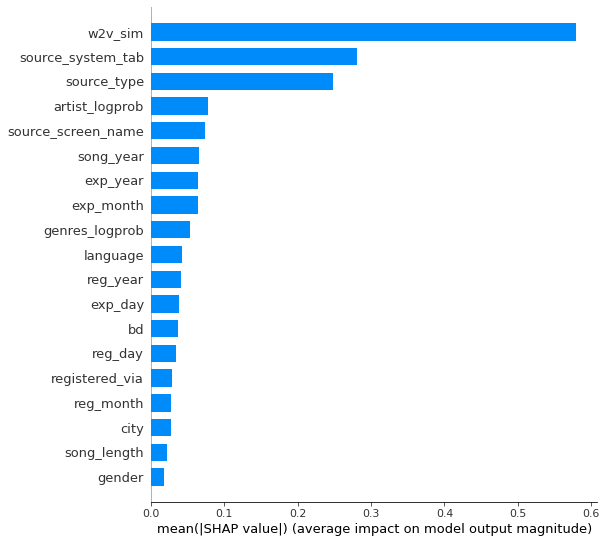

In [87]:
shap.summary_plot(shap_values, X_explain, plot_type='bar')

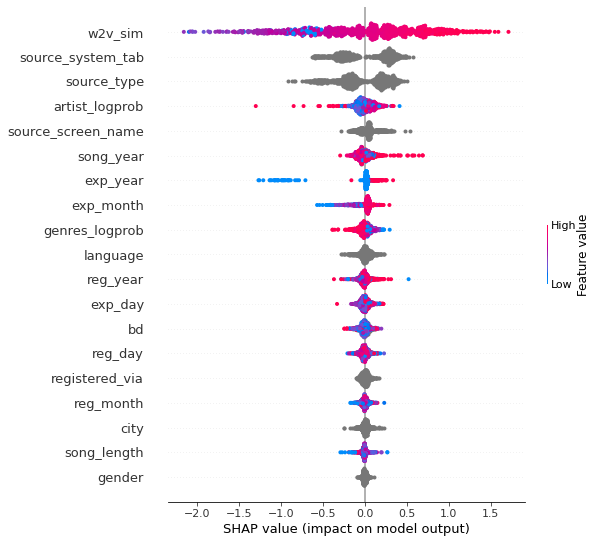

In [85]:
shap.summary_plot(shap_values, X_explain)

Видно, что фича w2v_sim имеет самое большое влияние на предсказания модели.